# 1. Read in data.

In [20]:
# Import packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta

In [16]:
# Run generate_health_data.py and read in datasets

df_baseline = pd.read_csv("patient_baseline.csv", sep = '\t')
df_longitudinal = pd.read_csv("patient_longitudinal.csv", sep = '\t')
df_treatment = pd.read_csv("patient_treatment.csv", sep = '\t')

df_baseline.head()

,patient_id,age,sex,bmi,smoking,diabetes,bp_systolic,cholesterol,heart_rate
0,0,57.5,0,25.8,0,0,108.7,257.9,79.3
1,1,47.9,0,23.2,0,0,149.4,155.9,75.4
2,2,59.7,1,29.0,0,0,136.7,220.7,85.0
3,3,72.8,1,34.6,0,1,141.0,205.7,78.0
4,4,46.5,0,17.5,0,0,129.0,186.8,95.2


# 2. Time Series Tasks

## 1. Convert the longitudinal blood pressure measurements into a proper time series:
   - Create a pandas Series with DatetimeIndex using `visit_date`
   - Handle any missing or duplicate measurements appropriately
   - Tips: 
     - Use `pd.to_datetime()` with format='%Y-%m-%d' for reliable parsing
     - Handle duplicates with `duplicated()` and appropriate aggregation
     - Consider timezone handling with `tz_localize()` if needed
     - Use `interpolate()` or `fillna()` for missing values

In [17]:
# Convert `visit_date` to datetime
df_longitudinal['visit_date'] = pd.to_datetime(df_longitudinal['visit_date'], format='%Y-%m-%d')

# Sort values by `patient_id` and `visit_date` for consistency
df_longitudinal = df_longitudinal.sort_values(by=['patient_id', 'visit_date'])

# Remove duplicates by averaging duplicated entries per `patient_id` and `visit_date`
df_longitudinal = df_longitudinal.groupby(['patient_id', 'visit_date']).agg({
    'bp_systolic': 'mean',
    'heart_rate': 'mean',
    'adverse_event': 'max',  # 1 if patient ever experienced cardiovascular event
    'age': 'first',
    'sex': 'first',
    'bmi': 'first',
    'smoking': 'first',
    'diabetes': 'first'
}).reset_index()

# Set up the DatetimeIndex and fill any missing values by interpolation
df_longitudinal.set_index('visit_date', inplace=True)

# Interpolate all numeric columns for missing values
df_longitudinal.interpolate(method='linear', inplace=True)

In [ ]:
# Check for missing values
print(df_longitudinal.isnull().sum())

df_longitudinal.head()

patient_id       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64


,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
visit_date,,,,,,,,,
2023-01-17,0,111.0,78.7,0,57.5,0.0,25.8,0.0,0.0
2023-09-23,0,112.0,79.5,0,57.5,0.0,25.8,0.0,0.0
2024-05-22,0,111.2,78.7,0,57.5,0.0,25.8,0.0,0.0
2024-12-31,0,109.2,79.5,0,57.5,0.0,25.8,0.0,0.0
2023-01-17,1,146.1,78.9,0,47.9,0.0,23.2,0.0,0.0


## 2. Analyze blood pressure trends:
   - Resample the data to monthly frequency using mean aggregation
   - Calculate 3-month moving averages to smooth out short-term fluctuations
   - Visualize both the original and smoothed trends
   - Tips:
     - Use `resample('ME').mean()` for month-end frequency
     - Add `min_periods` to `rolling()` to handle edge cases
     - Consider `interpolate()` method for gaps
     - Use `ewm()` for exponential weighted alternatives

In [25]:
# Resample to monthly frequency using mean aggregation
df_monthly = df_longitudinal['bp_systolic'].resample('ME').mean() # 'M' is deprecated, use 'ME'

# df_monthly.head()

# Interpolate missing values (if any) after resampling
df_monthly = df_monthly.interpolate()

# Calculate the 3-month moving average, set min_periods
df_monthly_smoothed = df_monthly.rolling(window=3, min_periods=1).mean()

# Calculate exponential weighted moving average (EWMA) for smoother trends
df_monthly_ewm = df_monthly.ewm(span=3, adjust=False).mean()

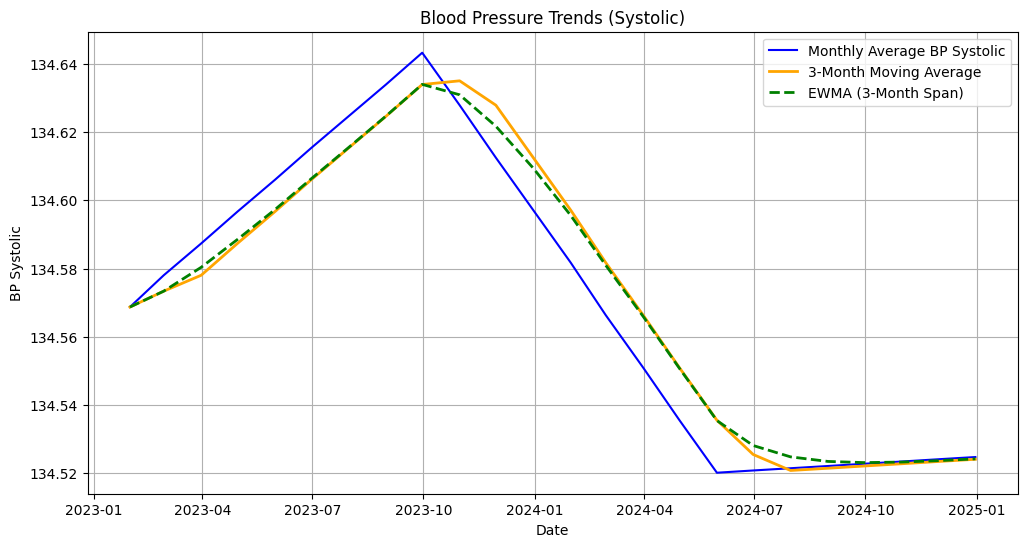

In [26]:
# Plotting the original and smoothed trends
plt.figure(figsize=(12, 6))

# Plot original monthly resampled data
plt.plot(df_monthly, label='Monthly Average BP Systolic', color='blue', linewidth=1.5)

# Plot 3-month moving average
plt.plot(df_monthly_smoothed, label='3-Month Moving Average', color='orange', linewidth=2)

# Plot Exponentially Weighted Moving Average (EWMA)
plt.plot(df_monthly_ewm, label='EWMA (3-Month Span)', color='green', linestyle='--', linewidth=2)

# Labels and legend
plt.title('Blood Pressure Trends (Systolic)')
plt.xlabel('Date')
plt.ylabel('BP Systolic')
plt.legend()
plt.grid()

# Display the plot
plt.show()

# Statistical Modeling Tasks

## 1. Analyze factors affecting baseline blood pressure:
   - Use statsmodels OLS to predict `bp_systolic`
   - Include `age`, `bmi`, `smoking`, and `diabetes` as predictors
   - Interpret the coefficients and their p-values
   - Assess model fit using R-squared and diagnostic plots
   - Tips:
     - Create feature matrix `X` with predictors and add constant term using `sm.add_constant()`
     - Use `sm.OLS(y, X).fit()` to fit the model
     - Use `summary()` to examine p-values and confidence intervals
     - Plot residuals vs fitted values and Q-Q plot
     - Consider robust standard errors with `HC3` covariance type

,patient_id,bp_systolic,heart_rate,adverse_event,age,sex,bmi,smoking,diabetes
visit_date,,,,,,,,,
2023-01-17,0,111.0,78.7,0,57.5,0.0,25.8,0.0,0.0
2023-09-23,0,112.0,79.5,0,57.5,0.0,25.8,0.0,0.0
2024-05-22,0,111.2,78.7,0,57.5,0.0,25.8,0.0,0.0
2024-12-31,0,109.2,79.5,0,57.5,0.0,25.8,0.0,0.0
2023-01-17,1,146.1,78.9,0,47.9,0.0,23.2,0.0,0.0
